In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
import h5py
import numpy as np
import pandas as pd
import torch
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger, TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import StratifiedGroupKFold, cross_val_predict
from torch.utils.data import DataLoader, Dataset, Sampler
from torch.nn.functional import cross_entropy
from tqdm import tqdm

from src.models import *

In [3]:
def prepare_data(sasa_or_bfactor: str, emb_type: str = 'both', debug: int = 0):
    if sasa_or_bfactor == 'sasa':
        data_type = 'sasa'
        train = pd.read_csv(f'data/e_prsa/train.tsv', sep='\t')
        train['label'] = train['RSA']
    else:
        data_type = 'bfactor'
        train = pd.read_csv(f'data/e_prsa/bfactor/train_with_uni.tsv', sep='\t')
        train['label'] = train['norm_Bfactor']
        

    input_features = []
    ys = []
    pids = np.array(train['Protein'].unique())
    uniprots = []

    for idx, pid in tqdm(enumerate(train['Protein'].unique())):
        train_protein = train[train['Protein'] == pid]
        uniprot = train_protein['UniProt'].values[0]
        uniprots.append(uniprot)
        y = train_protein['label'].values.astype(np.float32)
        input_feature = None
        with h5py.File(f'data/e_prsa/prott5_sasa_bfactor.h5', 'r') as p5, h5py.File(f'data/e_prsa/esm_sasa_bfactor.h5', 'r') as esm:
            try:
                #processed_pids = [pid.replace("-", "_").replace(".", "_") for pid in pids] 
                input_feature = np.concatenate([p5[pid][()], esm[pid][()]], axis=1)
            except:
                print(f"Error with {pid}")
                continue
            ys.append(y)
            if emb_type == 'esm':
                input_features.append(input_feature[:,1024:])
            elif emb_type == 'prott5':
                input_features.append(input_feature[:,:1024])
            else:
                input_features.append(input_feature)
    input_features = np.array(input_features, dtype=object)
    uniprots = np.array(uniprots, dtype=object)
    ys = np.array(ys, dtype=object)
    return input_features, ys, pids, uniprots


In [8]:
# create debug dataset
input_features_sasa = np.random.rand(128, 100, 2304).astype(np.float32)
sasa = np.random.rand(128, 100).astype(np.float32)
pids_sasa = np.random.rand(128)
uniprot_sasa = np.random.rand(128)

In [4]:
input_features_sasa, sasa, pids_sasa, uniprot_sasa = prepare_data('sasa', 'both')

6552it [11:31,  9.48it/s]


In [3]:
class ProteinDataset(Dataset):
    def __init__(self, protein_embeddings, protein_labels, pids):
        """
        Args:
            protein_embeddings (list of tensors): List of (L, D) tensors, where
                                                  L = length of protein, D = embedding size.
            protein_labels (list of tensors): List of (L,) tensors containing labels for each residue.
            protein_ids (list of str): List of protein IDs corresponding to each protein.
        """
        assert len(protein_embeddings) == len(protein_labels) == len(pids)
        self.protein_embeddings = protein_embeddings
        self.protein_labels = protein_labels
        self.pids = pids
        self.indices = []
        
        for i, embedding in enumerate(protein_embeddings):
            length = embedding.shape[0]
            self.indices.extend([(i, j) for j in range(length)])
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        protein_idx, residue_idx = self.indices[idx]
        embedding = self.protein_embeddings[protein_idx]
        label = self.protein_labels[protein_idx]
        pid = self.pids[protein_idx]
        return protein_idx, residue_idx, embedding[residue_idx], label[residue_idx], pid

class ResidueBatchSampler(Sampler):
    def __init__(self, dataset, batch_size, window_size, shuffle=True, drop_last=False):
        """
        Args:
            dataset (ProteinDataset): Dataset of protein embeddings.
            batch_size (int): Number of residues per batch.
            window_size (int): Total window size. Must be odd !
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.window_size = window_size // 2  # Half on each side
        self.shuffle = shuffle
        self.drop_last = drop_last
    
    def __iter__(self):
        if self.shuffle:
            indices = torch.randperm(len(self.dataset)) 
        else:
            indices = torch.arange(len(self.dataset))
        batch = []
        for idx in indices:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if batch and not self.drop_last:
            yield batch
    
    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

def collate_fn(batch, dataset, window_size):
    """
    Custom collate function to extract neighborhoods, labels, and pids.
    Args:
        batch: List of (protein_idx, residue_idx, embedding, label, pid) from the dataset.
        dataset: ProteinDataset object.
        window_size: Total window size for neighborhoods.
    Returns:
        - neighborhoods: Tensor (batch_size, window_size, embedding_dim).
        - labels: Tensor (batch_size,).
        - pids: List of protein IDs corresponding to each residue in the batch.
    """
    assert window_size % 2 == 1, "Window size must be odd"
    half_window = window_size // 2
    embedding_dim = dataset.protein_embeddings[0].shape[1]
    neighborhoods, labels, pids = [], [], []
    
    for protein_idx, residue_idx, _, label, pid in batch:
        protein = dataset.protein_embeddings[protein_idx]
        start = max(0, residue_idx - half_window)
        end = min(protein.shape[0], residue_idx + half_window + 1)
        
        neighborhood = torch.zeros((window_size, embedding_dim))  # Pad to window size
        neighborhood[:end-start] = torch.tensor(protein[start:end])
        neighborhoods.append(neighborhood)
        
        labels.append(label)
        pids.append(pid)
    
    neighborhoods = torch.stack(neighborhoods)
    labels = torch.tensor(labels)
    return neighborhoods, labels, pids
'''
Example usage:
dataset = ProteinDataset(proteins, labels, pids)
batch_size = 8
window_size = 31  # 15 upstream + 1 center + 15 downstream

sampler = ResidueBatchSampler(dataset, batch_size, window_size)
dataloader = DataLoader(dataset, batch_sampler=sampler, collate_fn=lambda x: collate_fn(x, dataset, window_size))
'''

'\nExample usage:\ndataset = ProteinDataset(proteins, labels, pids)\nbatch_size = 8\nwindow_size = 31  # 15 upstream + 1 center + 15 downstream\n\nsampler = ResidueBatchSampler(dataset, batch_size, window_size)\ndataloader = DataLoader(dataset, batch_sampler=sampler, collate_fn=lambda x: collate_fn(x, dataset, window_size))\n'

In [5]:
class CVDataset(Dataset):
    def __init__(self, input_features, ys, pids):
        self.input_features = input_features
        self.ys = ys
        self.pids = pids

    def __len__(self):
        return len(self.ys)

    def __getitem__(self, idx):
        return self.input_features[idx], self.ys[idx], self.pids[idx]

In [15]:
def train_normal_batching(X, y, pids, uniprots, input_size, task_type: str):
    test_pids = []
    window_size = 31
    with open('data/e_prsa/cross_validation/test.txt', 'r') as f:
        test_pids = f.read().splitlines()
    test_idx = [idx for idx, pid in enumerate(uniprots) if pid in test_pids]
    train_idx = [idx for idx, pid in enumerate(uniprots) if pid not in test_pids]
    X_train, y_train, uniprots_train = X[train_idx], y[train_idx], uniprots[train_idx]
    X_validation, y_validation, uniprots_validation = X[test_idx], y[test_idx], uniprots[test_idx]
    train_dataset = ProteinDataset(X_train, y_train, uniprots_train)
    validation_dataset = ProteinDataset(X_validation, y_validation, uniprots_validation)
    print(len(validation_dataset))
    sampler_train = ResidueBatchSampler(train_dataset, 64, window_size, shuffle=True)
    train_dl = DataLoader(train_dataset, batch_sampler=sampler_train, collate_fn=lambda x: collate_fn(x, train_dataset, window_size), num_workers=3)
    
    sampler_validation = ResidueBatchSampler(validation_dataset, 64, window_size, shuffle=False)
    validation_dl = DataLoader(validation_dataset, batch_sampler=sampler_validation, collate_fn=lambda x: collate_fn(x, validation_dataset, window_size), num_workers=1)
    print(len(validation_dl))
    model = BfactorSASACNN(task_type=task_type)
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)
    #tensor_b = TensorBoardLogger('tb_logs', 
    #                            name=f'{task_type}_{input_size}_normal', 
    #                            default_hp_metric=False)
    #tensor_b = WandbLogger(name=f'glyco_{glyco_class}_cv_{idx}', project='protein_properties_cv')
    trainer = Trainer(max_epochs=60,
                    enable_progress_bar=False, 
                    num_sanity_val_steps=2, 
                    #logger=tensor_b,
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=4), checkpoint_callback])        
    trainer.fit(model, train_dl, validation_dl)
    
    

In [ ]:
def train_normal(X, y, pids, uniprots, input_size, task_type: str):
    test_pids = []
    with open('data/e_prsa/cross_validation/test.txt', 'r') as f:
        test_pids = f.read().splitlines()
    test_idx = [idx for idx, pid in enumerate(uniprots) if pid in test_pids]
    train_idx = [idx for idx, pid in enumerate(uniprots) if pid not in test_pids]
    X_train, y_train, uniprots_train = X[train_idx], y[train_idx], uniprots[train_idx]
    X_validation, y_validation, uniprots_validation = X[test_idx], y[test_idx], uniprots[test_idx]
    train_dataset = CVDataset(X_train, y_train, uniprots_train)
    validation_dataset = CVDataset(X_validation, y_validation, uniprots_validation)
    train_dl = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_dl = DataLoader(validation_dataset, batch_size=1, shuffle=False)
    model = SASACNN(input_features=input_size, dropout=0.13, lr=0.00007, num_lin_layers=2, size_lin_layers=[64, 16])
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)
    tensor_b = TensorBoardLogger('tb_logs', 
                                name=f'{task_type}_{input_size}_normal', 
                                default_hp_metric=False)
    #tensor_b = WandbLogger(name=f'glyco_{glyco_class}_cv_{idx}', project='protein_properties_cv')
    trainer = Trainer(max_epochs=60, 
                    accumulate_grad_batches=18, 
                    enable_progress_bar=False, 
                    num_sanity_val_steps=2, 
                    logger=tensor_b,
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=4), checkpoint_callback])        
    trainer.fit(model, train_dl, val_dl)
    

In [ ]:
def train_cv(X, y, pids, uniprots,input_size):
    
    test_pids = []
    with open('data/e_prsa/cross_validation/test.txt', 'r') as f:
        test_pids = f.read().splitlines()
    test_idx = [idx for idx, pid in enumerate(uniprots) if pid in test_pids]
    train_idx = [idx for idx, pid in enumerate(uniprots) if pid not in test_pids]
    X_train, y_train, uniprots_train = X[train_idx], y[train_idx], uniprots[train_idx]
    X_test, y_test, uniprots_test = X[test_idx], y[test_idx], uniprots[test_idx]
    test_dl = DataLoader(CVDataset(X_test, y_test, uniprots_test), batch_size=1, shuffle=False)
    cv_metrics = {}
    for i in range(10):
        validation_pids = []
        with open(f'data/e_prsa/cross_validation/cv{i}.txt', 'r') as f:
            validation_pids = f.read().splitlines()
        validation_idx = [idx for idx, pid in enumerate(uniprots_train) if pid in validation_pids]
        train_idx = [idx for idx in range(len(uniprots_train)) if idx not in validation_idx]
        X_train, y_train, pids_train = X[train_idx], y[train_idx], uniprots_train[train_idx]
        X_validation, y_validation, pids_validation = X[validation_idx], y[validation_idx], uniprots_train[validation_idx]
        train_dataset = CVDataset(X_train, y_train, pids_train)
        validation_dataset = CVDataset(X_validation, y_validation, pids_validation)
        train_dl = DataLoader(train_dataset, batch_size=1, shuffle=True)
        val_dl = DataLoader(validation_dataset, batch_size=1, shuffle=False)
        model = SASACNN(input_features=input_size, dropout=0.13, lr=0.00007, num_lin_layers=2, size_lin_layers=[64, 16])
        checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)
        tensor_b = TensorBoardLogger('tb_logs', 
                                     name=f'SASA_{input_size}_cv_{i}', 
                                     default_hp_metric=False)
        #tensor_b = WandbLogger(name=f'glyco_{glyco_class}_cv_{idx}', project='protein_properties_cv')
        trainer = Trainer(max_epochs=30, 
                          accumulate_grad_batches=18, 
                          enable_progress_bar=False, 
                          num_sanity_val_steps=2, 
                          logger=tensor_b,
                          callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=4), checkpoint_callback])        
        trainer.fit(model, train_dl, val_dl)
        
        y_pred_val = trainer.predict(ckpt_path='best', 
                                     dataloaders=val_dl)
        val_loss = np.array([loss[1] for loss in y_pred_val]).mean()
        val_pcc = np.array([metric[3] for metric in y_pred_val]).mean()
        val_mae = np.array([metric[2] for metric in y_pred_val]).mean()
        #loss_val = cross_entropy(torch.tensor(y_pred_val), torch.tensor(val_y).long())
        
        y_pred_train = trainer.predict(ckpt_path='best', 
                                       dataloaders=DataLoader(train_dataset, batch_size=1, shuffle=False))
        train_loss = np.array([loss[1] for loss in y_pred_train]).mean()
        train_pcc = np.array([metric[3] for metric in y_pred_train]).mean()
        train_mae = np.array([metric[2] for metric in y_pred_train]).mean()

        y_pred_test = trainer.predict(ckpt_path='best', 
                                      dataloaders=test_dl)
        test_loss = np.array([loss[1] for loss in y_pred_test]).mean()
        test_pcc = np.array([metric[3] for metric in y_pred_test]).mean()
        test_mae = np.array([metric[2] for metric in y_pred_test]).mean()
        
        #loss_train = cross_entropy(torch.tensor(y_pred_train), torch.tensor(train_y).long())
        
        cv_metrics[f'fold_{i}'] = {
            'pcc_train': train_pcc,
            'mae_train': train_mae,
            'loss_train': train_loss,
            'pcc_val': val_pcc,
            'mae_val': val_mae,
            'loss_val': val_loss,
            'pcc_test': test_pcc,
            'mae_test': test_mae,
            'loss_test': test_loss,
            'model': checkpoint_callback.best_model_path
        }
    return cv_metrics


In [7]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
sasa_esm_prott5_normal = train_cv(input_features_sasa, sasa, pids_sasa, uniprot_sasa, 2304)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | cnn           | Conv1d     | 73.7 K
1 | linear_layers | Sequential | 148 K 
2 | sigmoid       | Sigmoid    | 0     
3 | softmax       | Softmax    | 0     
---------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.889     Total estimated model params size (MB)
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init 

In [ ]:
print(sasa_esm_prott5_normal)

In [13]:
sasa_esm_prott5_cv_metrics = train_normal(input_features_sasa, sasa, pids_sasa, uniprot_sasa, 2304, 'SASACNN')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | cnn           | Conv1d     | 73.7 K
1 | linear_layers | Sequential | 148 K 
2 | sigmoid       | Sigmoid    | 0     
3 | softmax       | Softmax    | 0     
---------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.889     Total estimated model params size (MB)


In [ ]:
sasa_esm_cv_metrics = train_normal(esm2_sasa, sasa, pids_sasa, uniprot_sasa, 1280)

In [ ]:
prott5_sasa, sasa, pids_sasa, uniprot_sasa = prepare_data('sasa', 'prott5')

6543it [11:47,  9.25it/s]


In [ ]:
sasa_prott5_cv_metrics = train_normal(prott5_sasa, sasa, pids_sasa, uniprot_sasa, 1024)

In [ ]:
input_features_bfactor, bfactor, pids_bfactor, uniprot_bfactor = prepare_data('bfactor', 'both')

6543it [10:29, 10.39it/s]


In [ ]:
bfactor_esm_prott5_cv_metrics = train_normal(input_features_bfactor, bfactor, pids_bfactor, uniprot_bfactor, 2304, 'bfactor')

In [ ]:
bfactor_esm_cv_metrics = train_normal(esm2, bfactor, pids)

In [ ]:
bfaactor_prott5_cv_metrics = train_normal(prott5, bfactor, pids)

## Test time

In [1]:
import math
import os
from pathlib import Path

import h5py
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import tensorflow as tf
import torch
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
)
from torch.utils.data import DataLoader, Dataset

from src.utils import mean_confidence_interval

basedir = "/home/d/PycharmProjects/protein_properties"
os.chdir(basedir)
import torch.nn as nn

from src.models import *

2024-12-15 18:49:41.215949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734284981.232939  175445 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734284981.238449  175445 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 18:49:41.254352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BDataset(Dataset):
    def __init__(self, input_features, ys, pids):
        self.input_features = input_features
        self.ys = ys
        self.pids = pids

    def __len__(self):
        return len(self.ys)

    def __getitem__(self, idx):

        return self.input_features[idx].astype(np.float32), self.ys[idx], self.pids[idx]

In [3]:
def load_dataset(csv_file, embed_dir, embed_type):
    data = pd.read_csv(csv_file, sep='\t')
    embed_dir = Path(embed_dir)
    embeddings = []
    labels = []
    pids = set(data['PDB'])
    with h5py.File(embed_dir / 'prott5_sasa_bfactor.h5', 'r') as prott5, h5py.File(embed_dir / 'esm_sasa_bfactor.h5', 'r') as esm:
        for pid in pids:
            label = data[data['PDB'] == pid]['RSA'].values
            try:
                prott5_embed = prott5[pid][:]
                esm_embed = esm[pid][:]
            except KeyError:
                print(f'Protein {pid} not found in embeddings')
                continue
            if embed_type == 'both':
                embeddings.append(np.concatenate([prott5_embed, esm_embed], axis=1))
            elif embed_type == 'prott5':
                embeddings.append(prott5_embed)
            elif embed_type == 'esm':
                embeddings.append(esm_embed)
            labels.append(label)
    return np.array(embeddings, dtype=object), np.array(labels, dtype=object), pids

In [4]:
def get_metrics_normal_batching(preds, ys, pids):
    pccs = []
    maes = []
    for protein in set(pids):
        idxs = [idx for idx, pid in enumerate(pids) if pid == protein]
        y_true = ys[idxs]
        y_pred = preds[idxs]
        y_true[y_true == -2] = -1
        mask = y_true != -1 
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        if len(y_true) == 0:
            continue
        pcc = pearsonr(y_true, y_pred)[0]
        mae = mean_absolute_error(y_true, y_pred)
        pccs.append(pcc)
        maes.append(mae)
    pccs_mean_conf = mean_confidence_interval(pccs)
    mae_mean_conf = mean_confidence_interval(maes)
    return np.mean(pccs), pccs_mean_conf, np.mean(maes), mae_mean_conf
    

In [5]:
def get_metrics(preds):
    average_pcc = 0
    average_mae = 0
    count = 0
    for sample in pred:
        if math.isnan(sample[3]):
            continue
        elif math.isnan(sample[2]):
            continue
        average_pcc += sample[3]
        average_mae += sample[2]
        count += 1
    pcc_mean, pcc_conf = mean_confidence_interval([sample[3] for sample in pred])
    mae_mean, mae_conf = mean_confidence_interval([sample[2] for sample in pred])
    return pcc_mean, pcc_conf, mae_mean, mae_conf

In [6]:
#model = BfactorSASACNN.load_from_checkpoint('tb_logs/SASA_normal_batch/epoch=3-step=110536.ckpt').to('cpu')
model = SASACNN.load_from_checkpoint('tb_bfactor/best_sasa_cv_epoch=26-step=8046.ckpt')

/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.0.4
  rank_zero_warn(


In [7]:
MM165_emb, MM165_bfactor, MM165_pids = load_dataset('data/e_prsa/MM165.tsv', 'data/e_prsa/', 'both')
MM165_pids = np.array(list(MM165_pids))
MM23_emb, MM23_bfactor, MM23_pids = load_dataset('data/e_prsa/MM23.tsv', 'data/e_prsa/', 'both')
MM23_pids = np.array(list(MM23_pids))
CASP12_emb, CASP12_bfactor, CASP12_pids = load_dataset('data/e_prsa/CASP12.tsv', 'data/e_prsa/', 'both')
CASP12_pids = np.array(list(CASP12_pids))
CASP14_emb, CASP14_bfactor, CASP14_pids = load_dataset('data/e_prsa/CASP14.tsv', 'data/e_prsa/', 'both')
CASP14_pids = np.array(list(CASP14_pids))


In [8]:
def create_test_dl(X, y, pids):
    #X = [torch.tensor(x).to('cuda:0') for x in X]
    #y = [torch.tensor(ys).to('cuda:0') for ys in y]
    pids = np.array(pids)
    test_dataset = ProteinDataset(X, y, pids)
    sampler_test = ResidueBatchSampler(test_dataset, 64, 31, shuffle=False)
    test_dl = DataLoader(test_dataset, batch_sampler=sampler_test, collate_fn=lambda x: collate_fn(x, test_dataset, 31))
    return test_dl

In [9]:
trainer = pl.Trainer(enable_progress_bar=False)

pred = trainer.predict(model, DataLoader(BDataset(MM165_emb, MM165_bfactor, MM165_pids), batch_size=1, shuffle=False))
mm165_pcc, mm165_pcc_conf, mm165_mae, mm165_mae_conf = get_metrics(pred)
pred = trainer.predict(model, DataLoader(BDataset(MM23_emb, MM23_bfactor, MM23_pids), batch_size=1, shuffle=False))
mm23_pcc, mm23_pcc_conf, mm23_mae, mm23_mae_conf = get_metrics(pred)
pred = trainer.predict(model, DataLoader(BDataset(CASP12_emb, CASP12_bfactor, CASP12_pids), batch_size=1, shuffle=False))
casp12_pcc, casp12_pcc_conf, casp12_mae, casp12_mae_conf = get_metrics(pred)
pred = trainer.predict(model, DataLoader(BDataset(CASP14_emb, CASP14_bfactor, CASP14_pids), batch_size=1, shuffle=False))
casp14_pcc, casp14_pcc_conf, casp14_mae, casp14_mae_conf = get_metrics(pred)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [10]:
print(f'MM165: PCC: {mm165_pcc} +/- {mm165_pcc_conf}, MAE: {mm165_mae} +/- {mm165_mae_conf}')
print(f'MM23: PCC: {mm23_pcc} +/- {mm23_pcc_conf}, MAE: {mm23_mae} +/- {mm23_mae_conf}')
print(f'CASP12: PCC: {casp12_pcc} +/- {casp12_pcc_conf}, MAE: {casp12_mae} +/- {casp12_mae_conf}')
print(f'CASP14: PCC: {casp14_pcc} +/- {casp14_pcc_conf}, MAE: {casp14_mae} +/- {casp14_mae_conf}')

MM165: PCC: 0.7698323726654053 +/- 0.017211877032214322, MAE: 0.12338214959238386 +/- 0.004207370258316442
MM23: PCC: 0.7407536506652832 +/- 0.07279097630083538, MAE: 0.1286965531455064 +/- 0.012727307308557404
CASP12: PCC: 0.6626068949699402 +/- 0.06732169252198572, MAE: 0.1530116681044132 +/- 0.015285596541750752
CASP14: PCC: 0.6053558588027954 +/- 0.07539253866668526, MAE: 0.17163415754436986 +/- 0.0255428186889762


In [11]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.linear_layers.register_forward_hook(get_activation('cnn'))
x = torch.randn(1, 100, 2304)
output = model(x)
print(activation['cnn'].shape)

torch.Size([1, 100, 1])


In [12]:
model = SASACNN.load_from_checkpoint('checkpoints/best_sasa_cv_epoch=26-step=8046.ckpt')

In [13]:
MM165_emb, MM165_bfactor, MM165_pids = load_dataset('data/e_prsa/MM165.tsv', 'data/e_prsa/', 'esm')
MM165_pids = np.array(list(MM165_pids))
MM23_emb, MM23_bfactor, MM23_pids = load_dataset('data/e_prsa/MM23.tsv', 'data/e_prsa/', 'esm')
MM23_pids = np.array(list(MM23_pids))
CASP12_emb, CASP12_bfactor, CASP12_pids = load_dataset('data/e_prsa/CASP12.tsv', 'data/e_prsa/', 'esm')
CASP12_pids = np.array(list(CASP12_pids))
CASP14_emb, CASP14_bfactor, CASP14_pids = load_dataset('data/e_prsa/CASP14.tsv', 'data/e_prsa/', 'esm')
CASP14_pids = np.array(list(CASP14_pids))

In [14]:
trainer = pl.Trainer(enable_progress_bar=False)

pred = trainer.predict(model, DataLoader(BDataset(MM165_emb, MM165_bfactor, MM165_pids), batch_size=1, shuffle=False))
pcc, mae = get_metrics(pred)
print(f'MM165: MAE: {mae}, PCC: {pcc}')

pred = trainer.predict(model, DataLoader(BDataset(MM23_emb, MM23_bfactor, MM23_pids), batch_size=1, shuffle=False))
pcc, mae = get_metrics(pred)
print(f'MM23: MAE:{mae}, PCC:{pcc}')

pred = trainer.predict(model, DataLoader(BDataset(CASP12_emb, CASP12_bfactor, CASP12_pids), batch_size=1, shuffle=False))
pcc, mae = get_metrics(pred)
print(f'CASP12: MAE:{mae}, PCC:{pcc}')

pred = trainer.predict(model, DataLoader(BDataset(CASP14_emb, CASP14_bfactor, CASP14_pids), batch_size=1, shuffle=False))
pcc, mae = get_metrics(pred)
print(f'CASP14: MAE:{mae}, PCC:{pcc}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


ValueError: too many values to unpack (expected 2)

### E-PRSA performance

In [ ]:
import pandas as pd 
from Bio import SeqIO
from src.utils import mean_confidence_interval
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import numpy as np

results = pd.read_csv('data/e_prsa/E-pRSA-results_all_test.tsv', sep='\t')
results.drop_duplicates(subset=['Protein', 'Pos'], inplace=True)
# split results into MM165, MM23, CASP12, CASP14
mm165 = [record.id for record in SeqIO.parse('data/e_prsa/MM165_seqs.fasta', 'fasta')]
mm23 = [record.id for record in SeqIO.parse('data/e_prsa/MM23_seqs.fasta', 'fasta')]
casp12 = [record.id for record in SeqIO.parse('data/e_prsa/CASP12_seqs.fasta', 'fasta')]
casp14 = [record.id for record in SeqIO.parse('data/e_prsa/CASP14_seqs.fasta', 'fasta')]

mm165_results = results[results['Protein'].isin(mm165)]
mm23_results = results[results['Protein'].isin(mm23)]
casp12_results = results[results['Protein'].isin(casp12)]
casp14_results = results[results['Protein'].isin(casp14)]
# real labels 
mm165_real = pd.read_csv('data/e_prsa/MM165.tsv', sep='\t')
mm23_real = pd.read_csv('data/e_prsa/MM23.tsv', sep='\t')
casp12_real = pd.read_csv('data/e_prsa/CASP12.tsv', sep='\t')
casp14_real = pd.read_csv('data/e_prsa/CASP14.tsv', sep='\t')
# merge real labels with results

# calculate PCC and MAE for each protein in each dataset
# afterwards calculate the mean and confidence interval for each dataset


def calculate_metrics(results, real):
    pcc = []
    mae = []
    ids = results['Protein'].unique()
    for id in ids:
        # mask -1 and -2 values
        
        protein_pred = results[results['Protein'] == id].sort_values('Pos')
        protein_pred = protein_pred['RSA'].values
        protein_real = real[real['PDB'] == id].sort_values('Pos')
        protein_real = protein_real['RSA'].values
        protein_mask = protein_real < 0
        
        pcc.append(pearsonr(protein_pred[~protein_mask], protein_real[~protein_mask])[0])
        mae.append(mean_absolute_error(protein_pred[~protein_mask], protein_real[~protein_mask]))
    pcc_mean, pcc_ci = mean_confidence_interval(pcc)
    mae_mean, mae_ci = mean_confidence_interval(mae)
    return pcc_mean, pcc_ci, mae_mean, mae_ci

mm165_pcc, mm165_pcc_ci, mm165_mae, mm165_mae_ci = calculate_metrics(mm165_results, mm165_real)
mm23_pcc, mm23_pcc_ci, mm23_mae, mm23_mae_ci = calculate_metrics(mm23_results, mm23_real)
casp12_pcc, casp12_pcc_ci, casp12_mae, casp12_mae_ci = calculate_metrics(casp12_results, casp12_real)
casp14_pcc, casp14_pcc_ci, casp14_mae, casp14_mae_ci = calculate_metrics(casp14_results, casp14_real)
print(f'MM165: PCC: {mm165_pcc}, CI: {mm165_pcc_ci}, MAE: {mm165_mae}, CI: {mm165_mae_ci}')
print(f'MM23: PCC: {mm23_pcc}, CI: {mm23_pcc_ci}, MAE: {mm23_mae}, CI: {mm23_mae_ci}')
print(f'CASP12: PCC: {casp12_pcc}, CI: {casp12_pcc_ci}, MAE: {casp12_mae}, CI: {casp12_mae_ci}')
print(f'CASP14: PCC: {casp14_pcc}, CI: {casp14_pcc_ci}, MAE: {casp14_mae}, CI: {casp14_mae_ci}')



MM165: PCC: 0.7799538119712838, CI: 0.01716972480613251, MAE: 0.12402876333348484, CI: 0.00432656438582616
MM23: PCC: 0.7520225588931531, CI: 0.07054942323780648, MAE: 0.13059180745823634, CI: 0.014416048194101305
CASP12: PCC: 0.6985041172049863, CI: 0.06808203627563918, MAE: 0.148678507512557, CI: 0.015346334894529435
CASP14: PCC: 0.6118135242815721, CI: 0.06299031228425951, MAE: 0.17283292582201523, CI: 0.02436127609348263


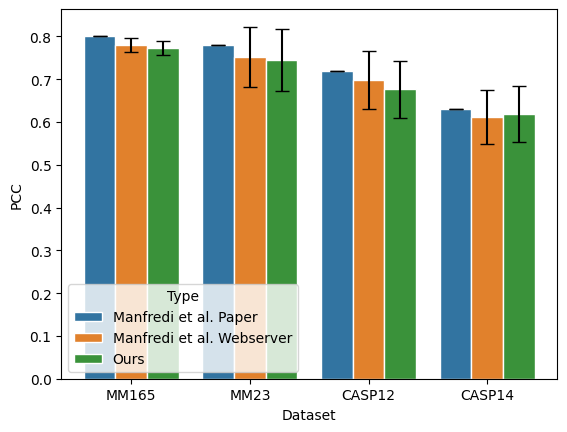

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

paper_results = {
        'MM165': 0.80,
        'MM23': 0.78,
        'CASP12': 0.72,
        'CASP14': 0.63
        }
paper_results_ci = {
        'MM165': 0.0,
        'MM23': 0.0,
        'CASP12': 0.0,
        'CASP14': 0.0
        }
our_results = {
        'MM165': 0.7727585434913635,
        'MM23': 0.7453992366790771,
        'CASP12': 0.6768952012062073,
        'CASP14': 0.6181190609931946
        }
our_results_ci = {
        'MM165': 0.017343534207094512,
        'MM23': 0.07188874885767038,
        'CASP12': 0.06659022842990402,
        'CASP14': 0.06574200066479703
        }
results = {
        'MM165': mm165_pcc,
        'MM23': mm23_pcc,
        'CASP12': casp12_pcc,
        'CASP14': casp14_pcc
        }
results_ci = {
        'MM165': mm165_pcc_ci,
        'MM23': mm23_pcc_ci,
        'CASP12': casp12_pcc_ci,
        'CASP14': casp14_pcc_ci
        }
paper_results = pd.DataFrame(paper_results.items(), columns=['Dataset', 'PCC'])
paper_results['Type'] = 'Manfredi et al. Paper'
paper_results['CI'] = list(paper_results_ci.values())
results = pd.DataFrame(results.items(), columns=['Dataset', 'PCC'])
results['Type'] = 'Manfredi et al. Webserver'
results['CI'] = list(results_ci.values())
ours = pd.DataFrame(our_results.items(), columns=['Dataset', 'PCC'])
ours['Type'] = 'Ours'
ours['CI'] = list(our_results_ci.values())
df = pd.concat([paper_results, results, ours])
fig, ax = plt.subplots()
barplot = sns.barplot(data=df, x='Dataset', y='PCC', hue='Type', ax=ax, edgecolor='white')
# add error bars which should be at the center of the bar
for i, bar in enumerate(barplot.patches):
    # Get the center of the bar
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Get the corresponding CI value
    ci = df.iloc[i]['CI']
    # Add error bar
    ax.errorbar(x, y, yerr=ci, fmt='none', c='black', capsize=5)

plt.show()

### Dummy Baseline

In [ ]:
import src.models as mm
sasa_labels = pd.read_csv('data/e_prsa/train.tsv', sep='\t')['RSA']
dummy_model = mm.SASADummyModel(1, torch.tensor(sasa_labels)).cpu()
trainer = pl.Trainer(enable_progress_bar=False, accelerator='cpu')

pred = trainer.predict(dummy_model, DataLoader(BDataset(MM165_emb, MM165_bfactor, MM165_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'MM165: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(MM23_emb, MM23_bfactor, MM23_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'MM23: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(CASP12_emb, CASP12_bfactor, CASP12_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CASP12: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')
pred = trainer.predict(dummy_model, DataLoader(BDataset(CASP14_emb, CASP14_bfactor, CASP14_pids), batch_size=1, shuffle=False))
pcc, pcc_conf, mae, mae_conf = get_metrics(pred)
print(f'CASP14: PCC: {pcc} +/- {pcc_conf}, MAE: {mae} +/- {mae_conf}')

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


MM165: PCC: -0.007802745390594591 +/- 0.012743083301482655, MAE: 0.41543997633087687 +/- 0.006809955014442729
MM23: PCC: -0.011326705897019052 +/- 0.03090579364938998, MAE: 0.4263194338646233 +/- 0.016376371005140052
CASP12: PCC: -0.015480017350340278 +/- 0.02871387544502363, MAE: 0.43267834583467896 +/- 0.019823306659810594
CASP14: PCC: -0.03862912288664012 +/- 0.05033657646231647, MAE: 0.4378117596620328 +/- 0.044094282334492155


### VespaG baseline

### SASA

In [15]:
def load_vespa_data(pids, embed_dir):
    vespa_scores = []
    bad_pids = []
    embed_dir = Path(embed_dir)
    with h5py.File(embed_dir / "vespag_scores_all.h5", "r") as vesp:
        for pid in pids:
            try:
                vespa_score = vesp[pid][()]
            except(KeyError, IndexError):
                print('DIE MF')
                bad_pids.append(pid)
                continue
            vespa_scores.append(vespa_score)
    return np.array(vespa_scores, dtype=object), bad_pids

In [24]:
train = pd.read_csv('data/e_prsa/train.tsv', sep='\t')
# sample 1000 random proteins
pids = train['Protein'].unique()
pids_sample = np.random.choice(pids, 8, replace=False)
train = train[train['Protein'].isin(pids_sample)]
vespa_scores, bad_pids = load_vespa_data(pids_sample, 'data/e_prsa/')
# sample 1000 random proteins
vespa_labels = train['RSA'].values
vespa_scores = np.concatenate(vespa_scores, axis=0)
vespa_labels = vespa_labels.reshape(-1) 


In [25]:
#rf = RandomForestRegressor(random_state=42).fit(vespa_scores, vespa_labels)
linreg = LinearRegression().fit(vespa_scores, vespa_labels)

In [18]:
mm165_vespa_scores, _ = load_vespa_data(MM165_pids, 'data/e_prsa/')
mm165_vespa_scores = np.concatenate(mm165_vespa_scores, axis=0)
mm165_vespa_labels = np.concatenate(MM165_bfactor, axis=0)
mm23_vespa_scores, _ = load_vespa_data(MM23_pids, 'data/e_prsa/')
mm23_vespa_scores = np.concatenate(mm23_vespa_scores, axis=0)
mm23_vespa_labels = np.concatenate(MM23_bfactor, axis=0)
casp12_vespa_scores, _ = load_vespa_data(CASP12_pids, 'data/e_prsa/')
casp12_vespa_scores = np.concatenate(casp12_vespa_scores, axis=0)
cas12_vespa_labels = np.concatenate(CASP12_bfactor, axis=0)
casp14_vespa_scores, _ = load_vespa_data(CASP14_pids, 'data/e_prsa/')
casp14_vespa_scores = np.concatenate(casp14_vespa_scores, axis=0)
casp14_vespa_labels = np.concatenate(CASP14_bfactor, axis=0)

In [26]:
def evalute_vespa_scores(rf, vespa_scores, vespa_labels, pids):
    preds = rf.predict(vespa_scores)
    pccs = []
    maes = []
    for pid in pids:
        mask = (pids == pid) & (vespa_labels != -1) & (vespa_labels != -100)
        if mask.sum() == 0:
            continue
        pccs.append(pearsonr(preds[mask], vespa_labels[mask])[0])
        maes.append(mean_absolute_error(preds[mask], vespa_labels[mask]))
   
    pccs_mean, pccs_ci = mean_confidence_interval(pccs)
    maes_mean, maes_ci = mean_confidence_interval(maes)
    return pccs_mean, pccs_ci, maes_mean, maes_ci

def format_pids(label, pids):
    pids_ref = []
    for i, pid in zip(label, pids):
        pids_ref.extend([pid] * len(i))
    pids_ref = np.array(pids_ref)
    return pids_ref

pcc_mean, pcc_ci, mae_mean, mae_ci = evalute_vespa_scores(linreg, mm165_vespa_scores, mm165_vespa_labels, format_pids(MM165_bfactor, MM165_pids))
print(f'MM165: PCC: {pcc_mean} +/- {pcc_ci}, MAE: {mae_mean} +/- {mae_ci}')

pcc_mean, pcc_ci, mae_mean, mae_ci = evalute_vespa_scores(linreg, mm23_vespa_scores, mm23_vespa_labels, format_pids(MM23_bfactor, MM23_pids))
print(f'MM23: PCC: {pcc_mean} +/- {pcc_ci}, MAE: {mae_mean} +/- {mae_ci}')
pcc_mean, pcc_ci, mae_mean, mae_ci = evalute_vespa_scores(linreg, casp12_vespa_scores, cas12_vespa_labels, format_pids(CASP12_bfactor,CASP12_pids))
print(f'CASP12: PCC: {pcc_mean} +/- {pcc_ci}, MAE: {mae_mean} +/- {mae_ci}')
pcc_mean, pcc_ci, mae_mean, mae_ci = evalute_vespa_scores(linreg, casp14_vespa_scores, casp14_vespa_labels, format_pids(CASP14_bfactor, CASP14_pids))
print(f'CASP14: PCC: {pcc_mean} +/- {pcc_ci}, MAE: {mae_mean} +/- {mae_ci}')

MM165: PCC: 0.25230163926817784 +/- 0.001157482977421206, MAE: 0.24440063139210166 +/- 0.0006758562887873945
MM23: PCC: 0.1849589540122888 +/- 0.0027838806780144045, MAE: 0.29190537475224476 +/- 0.0013146461330848297
CASP12: PCC: 0.04522624907938232 +/- 0.0017417673908871809, MAE: 0.3364595330192707 +/- 0.001134033347503835
CASP14: PCC: 0.1013185537612976 +/- 0.0018821443172178092, MAE: 0.2796856274820527 +/- 0.0015196687072666743


### Plot it like it's hot

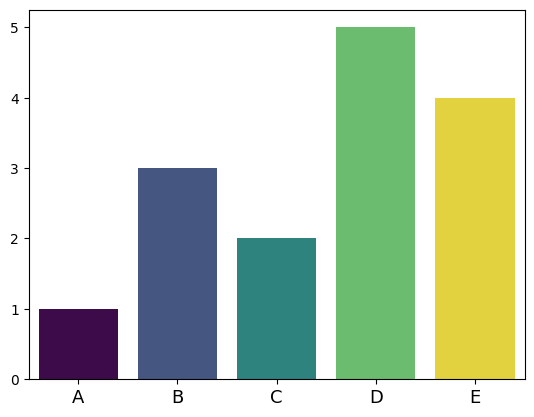

In [29]:
# first plot a bar chart for F1 MCC for all models
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex
import pandas as pd
from src.utils import mean_confidence_interval
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
plt.rcParams.update({
    "font.size": 12,  
    # Base font size
    "axes.titlesize": 16,      # Axis title font size
    "axes.labelsize": 15,      # Axis label font size
    "xtick.labelsize": 13,     # X-axis tick label font size
    "ytick.labelsize": 10      # Y-axis tick label font size
})
n_colors = 5
viridis = plt.cm.viridis
colors = [to_hex(viridis(i)) for i in np.linspace(0, 1, n_colors)]

# Apply the palette
custom_palette = sns.color_palette(colors)

# Example plot
sns.set_palette(custom_palette)
sns.barplot(x=["A", "B", "C", "D", "E"], y=[1, 3, 2, 5, 4])
plt.show()

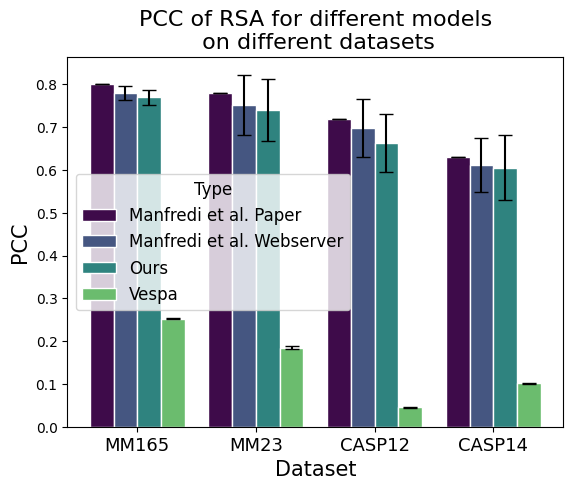

In [30]:
# plot results vs the results they put in the paper
# use CIs to plot error bars
# plot only the pcc
# use the results we caluclated above
'''
Manfredi et al. Paper results:
MM165: PCC: 0.80
MM23: PCC: 0.78
CASP12: PCC: 0.72
CASP14: PCC: 0.63

Our:
MM165: PCC: 0.7698323726654053 +/- 0.017211875886931124, MAE: 0.12338214959238386 +/- 0.004207370258316442
MM23: PCC: 0.7407537698745728 +/- 0.07279097630083538, MAE: 0.1286965531455064 +/- 0.012727307308557404
CASP12: PCC: 0.6626068949699402 +/- 0.06732169252198572, MAE: 0.1530116681044132 +/- 0.015285596541750752
CASP14: PCC: 0.6053559184074402 +/- 0.07539253866668526, MAE: 0.17163415754436986 +/- 0.0255428186889762

Our radondom baseline:
MM165: PCC: 0.004996343860784928 +/- 0.01281360529817669, MAE: 0.4156044497389947 +/- 0.006239340895525614
MM23: PCC: -0.004971906889461014 +/- 0.026851342249748042, MAE: 0.4349363973760093 +/- 0.013432208626028789
CASP12: PCC: -0.02552176856033525 +/- 0.024343998537522064, MAE: 0.4367425785193194 +/- 0.022584864229743363
CASP14: PCC: 0.006220471794867778 +/- 0.13906100747872008, MAE: 0.4217334447868402 +/- 0.02387423526597131

Vespag baseline:
MM165: PCC: 0.25230163926817784 +/- 0.001157482977421206, MAE: 0.24440063139210166 +/- 0.0006758562887873945
MM23: PCC: 0.1849589540122888 +/- 0.0027838806780144045, MAE: 0.29190537475224476 +/- 0.0013146461330848297
CASP12: PCC: 0.04522624907938232 +/- 0.0017417673908871809, MAE: 0.3364595330192707 +/- 0.001134033347503835
CASP14: PCC: 0.1013185537612976 +/- 0.0018821443172178092, MAE: 0.2796856274820527 +/- 0.0015196687072666743

Matteo et al. Webserver
MM165: PCC: 0.7799538119712838, CI: 0.01716972480613251, MAE: 0.12402876333348484, CI: 0.00432656438582616
MM23: PCC: 0.7520225588931531, CI: 0.07054942323780648, MAE: 0.13059180745823634, CI: 0.014416048194101305
CASP12: PCC: 0.6985041172049863, CI: 0.06808203627563918, MAE: 0.148678507512557, CI: 0.015346334894529435
CASP14: PCC: 0.6118135242815721, CI: 0.06299031228425951, MAE: 0.17283292582201523, CI: 0.02436127609348263


'''
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

paper_results = {
        'MM165': 0.80,
        'MM23': 0.78,
        'CASP12': 0.72,
        'CASP14': 0.63
        }
paper_results_ci = {
        'MM165': 0.0,
        'MM23': 0.0,
        'CASP12': 0.0,
        'CASP14': 0.0
        }
our_results = {
        'MM165': 0.7698323726654053,
        'MM23': 0.7407537698745728,
        'CASP12': 0.6626068949699402,
        'CASP14': 0.6053559184074402
        }
our_results_ci = {
        'MM165': 0.017211875886931124,
        'MM23': 0.07279097630083538,
        'CASP12': 0.06732169252198572,
        'CASP14': 0.07539253866668526
        }
vespa_results = {
        'MM165': 0.25230163926817784,
        'MM23': 0.1849589540122888,
        'CASP12': 0.04522624907938232,
        'CASP14': 0.1013185537612976
        }
vespa_results_ci = {
        'MM165': 0.001157482977421206,
        'MM23': 0.0027838806780144045,
        'CASP12': 0.0017417673908871809,
        'CASP14': 0.0018821443172178092
        }

webserver_results = {
        'MM165': 0.7799538119712838,
        'MM23': 0.7520225588931531,
        'CASP12': 0.6985041172049863,
        'CASP14': 0.6118135242815721
        }
webserver_results_ci = {
        'MM165': 0.01716972480613251,
        'MM23': 0.07054942323780648,
        'CASP12': 0.06808203627563918,
        'CASP14': 0.06299031228425951
        }
random_results = {
        'MM165': 0.004996343860784928,
        'MM23': -0.004971906889461014,
        'CASP12': -0.02552176856033525,
        'CASP14': 0.006220471794867778
        }
random_results_ci = {
        'MM165': 0.01281360529817669,
        'MM23': 0.026851342249748042,
        'CASP12': 0.024343998537522064,
        'CASP14': 0.13906100747872008
        }
paper_results = pd.DataFrame(paper_results.items(), columns=['Dataset', 'PCC'])
paper_results['Type'] = 'Manfredi et al. Paper'
paper_results['CI'] = list(paper_results_ci.values())
our_results = pd.DataFrame(our_results.items(), columns=['Dataset', 'PCC'])
our_results['Type'] = 'Ours'
our_results['CI'] = list(our_results_ci.values())
vespa_results = pd.DataFrame(vespa_results.items(), columns=['Dataset', 'PCC'])
vespa_results['Type'] = 'Vespa'
vespa_results['CI'] = list(vespa_results_ci.values())
webserver_results = pd.DataFrame(webserver_results.items(), columns=['Dataset', 'PCC'])
webserver_results['Type'] = 'Manfredi et al. Webserver'
webserver_results['CI'] = list(webserver_results_ci.values())
random_results = pd.DataFrame(random_results.items(), columns=['Dataset', 'PCC'])
random_results['Type'] = 'Random'
random_results['CI'] = list(random_results_ci.values())
df = pd.concat([paper_results, webserver_results, our_results, vespa_results])
fig, ax = plt.subplots()
barplot = sns.barplot(data=df, x='Dataset', y='PCC', hue='Type', ax=ax, edgecolor='white', palette=custom_palette)
# add error bars which should be at the center of the bar
for i, bar in enumerate(barplot.patches):
    # Get the center of the bar
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    # Get the corresponding CI value
    ci = df.iloc[i]['CI']
    # Add error bar
    ax.errorbar(x, y, yerr=ci, fmt='none', c='black', capsize=5)
plt.ylabel('PCC')
plt.xlabel('Dataset')
plt.title('PCC of RSA for different models\n on different datasets')
plt.savefig('results/plots/SASA_pcc.png', dpi=400, bbox_inches = "tight")
plt.show()


In [31]:
df = pd.concat([paper_results, webserver_results, our_results, vespa_results, random_results])
df_dataset = df.pivot(index='Type', columns='Dataset', values='PCC').T
df_dataset = df_dataset.applymap(lambda x: f'{x:.3f}')
df_ci = df.pivot(index='Type', columns='Dataset', values='CI').T
df_ci = df_ci.applymap(lambda x: f'{x:.3f}')
df = df_dataset + ' +/- ' + df_ci
df.T

Dataset,CASP12,CASP14,MM165,MM23
Type,,,,
Manfredi et al. Paper,0.720 +/- 0.000,0.630 +/- 0.000,0.800 +/- 0.000,0.780 +/- 0.000
Manfredi et al. Webserver,0.699 +/- 0.068,0.612 +/- 0.063,0.780 +/- 0.017,0.752 +/- 0.071
Ours,0.663 +/- 0.067,0.605 +/- 0.075,0.770 +/- 0.017,0.741 +/- 0.073
Random,-0.026 +/- 0.024,0.006 +/- 0.139,0.005 +/- 0.013,-0.005 +/- 0.027
Vespa,0.045 +/- 0.002,0.101 +/- 0.002,0.252 +/- 0.001,0.185 +/- 0.003


In [51]:
import pickle
with open('tb_bfactor/bfactor_cv.pickle', 'rb') as f:
    bfactor_results = pickle.load(f)
with open('tb_bfactor/OPUS_bfactor_cv.pickle', 'rb') as f:
    opus_bfactor_results = pickle.load(f)
with open('tb_bfactor/sasa_cv.pkl', 'rb') as f:
    sasa_results = pickle.load(f)

In [52]:
sasa_results = pd.DataFrame(sasa_results)
bfactor_results = pd.DataFrame(bfactor_results)
opus_bfactor_results = pd.DataFrame(opus_bfactor_results)

In [38]:
sasa_results.T

,pcc_train,mae_train,loss_train,pcc_val,mae_val,loss_val,pcc_test,mae_test,loss_test,model
fold_0,0.814221,0.111511,0.02316,0.797429,0.114752,0.024635,0.811151,0.112234,0.023565,tb_logs/SASA_2304_cv_0/version_0/checkpoints/e...
fold_1,0.815407,0.111215,0.022953,0.800819,0.114135,0.0245,0.811482,0.112224,0.023433,tb_logs/SASA_2304_cv_1/version_0/checkpoints/e...
fold_2,0.812153,0.111639,0.023256,0.80139,0.11521,0.024831,0.809441,0.112567,0.023667,tb_logs/SASA_2304_cv_2/version_0/checkpoints/e...
fold_3,0.81286,0.111453,0.023262,0.788334,0.116435,0.025285,0.809747,0.112138,0.023611,tb_logs/SASA_2304_cv_3/version_0/checkpoints/e...
fold_4,0.812714,0.11157,0.023231,0.796117,0.116249,0.025174,0.810108,0.112355,0.023618,tb_logs/SASA_2304_cv_4/version_0/checkpoints/e...
fold_5,0.806051,0.113382,0.023941,0.795146,0.116906,0.025441,0.803645,0.114064,0.024324,tb_logs/SASA_2304_cv_5/version_0/checkpoints/e...
fold_6,0.811316,0.112348,0.02337,0.801003,0.115892,0.024949,0.809072,0.113027,0.023706,tb_logs/SASA_2304_cv_6/version_0/checkpoints/e...
fold_7,0.803787,0.114198,0.024255,0.790695,0.117613,0.025629,0.801312,0.114917,0.024623,tb_logs/SASA_2304_cv_7/version_0/checkpoints/e...
fold_8,0.815723,0.110173,0.022923,0.80144,0.11411,0.024628,0.813309,0.110939,0.023288,tb_logs/SASA_2304_cv_8/version_0/checkpoints/e...
fold_9,0.809394,0.112741,0.023571,0.800631,0.115366,0.024786,0.807168,0.113294,0.02389,tb_logs/SASA_2304_cv_9/version_0/checkpoints/e...


In [49]:
def return_cv_metrics(results):
    # each column is a metric
    # get the mean and CI for each metric
    results = results.T
    metrics = results.columns[:-1]
    mean_ci = {}
    mean = {}
    for metric in metrics:
        mean[metric], mean_ci[metric] = mean_confidence_interval(results[metric].values)
    print(f'Mean and CI for each metric')
    for metric in metrics:
        print(f'{metric}: {mean[metric]} +/- {mean_ci[metric]}')

In [57]:
print('SASA')
return_cv_metrics(sasa_results)

SASA
Mean and CI for each metric
pcc_train: 0.8113626956939697 +/- 0.002798248356053611
mae_train: 0.11202302351593971 +/- 0.000833350196348337
loss_train: 0.023392236718148864 +/- 0.0003022137890998045
pcc_val: 0.7973004102706909 +/- 0.003381688306978674
mae_val: 0.11566683799028396 +/- 0.0008333019801360304
loss_val: 0.0249857937137009 +/- 0.0002718070738513898
pcc_test: 0.8086433947086334 +/- 0.0026251818283929956
mae_test: 0.1127758875489235 +/- 0.000797081478144649
loss_test: 0.023772493754396166 +/- 0.0002920367595222378


In [58]:
print('Bfactor')
return_cv_metrics(bfactor_results)


Bfactor
Mean and CI for each metric
pcc_train: 0.6160383522510529 +/- 0.0015751608609552723
mae_train: 0.5651869356632233 +/- 0.0011054426078519095
loss_train: 0.6248180824240908 +/- 0.002179990042859041
pcc_val: 0.5898783028125762 +/- 0.0039617226545165226
mae_val: 0.5788383305072784 +/- 0.0022231553536126883
loss_val: 0.6569618882571786 +/- 0.004791759885551439
pcc_test: 0.5972003221511841 +/- 0.0009239389945563928
mae_test: 0.5720599889755249 +/- 0.0007195135778430585
loss_test: 0.647265096829094 +/- 0.001099585710128069


In [59]:
print('Opus Bfactor')
return_cv_metrics(opus_bfactor_results)

Opus Bfactor
Mean and CI for each metric
pcc_train: 0.6514855325222015 +/- 0.0026430089624248317
mae_train: 0.5546931982040405 +/- 0.002106038775169111
loss_train: 0.576714112214719 +/- 0.003484418772120632
pcc_val: 0.6229893386363983 +/- 0.0011577344836178755
mae_val: 0.5709429860115052 +/- 0.0013614638661734277
loss_val: 0.6141067768022189 +/- 0.0015230354095048075
pcc_test: 0.6206771075725556 +/- 0.0004683100868368868
mae_test: 0.5751321911811829 +/- 0.0008615432598910733
loss_test: 0.6177730110850688 +/- 0.0006765627348071792
